# PREDICTION FUEL EFFICIENCY OF VEHICLES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [214]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

In [208]:
from sklearn.linear_model import LinearRegression
from sklearn import tree

# Read Data

In [4]:
columns_names = ['mpg', 'cylinders', 'displacement', 'horsepower',
                'weight', 'acceleration', 'model_year', 'origin']
df = pd.read_csv('auto-mpg.data', names=columns_names, comment='\t', sep=' ', na_values='?',
                skipinitialspace=True)

In [5]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


# Exploratory Data Analysis (EDA)

#### Plan:
- Check data types of columns
- Check for null values
- Check for outliers
- Look for the category distribution in categorical columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [7]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [8]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


<AxesSubplot:xlabel='horsepower'>

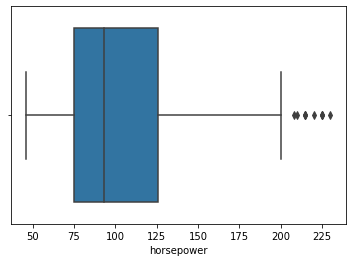

In [9]:
sns.boxplot(x=df['horsepower'])

In [10]:
horsepower_median = df.horsepower.median()
df.horsepower.fillna(horsepower_median, inplace=True)

In [11]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [12]:
df.cylinders.value_counts() / len(df)

4    0.512563
8    0.258794
6    0.211055
3    0.010050
5    0.007538
Name: cylinders, dtype: float64

In [13]:
df.origin.value_counts()

1    249
3     79
2     70
Name: origin, dtype: int64

# Data preparation

#### Plan:

- Handle Categorical attributes (OneHotEncoder)
- Data Cleaning - Imputer
- Attribute Addition - Adding custom transformations
- Setting up Data Transfromation Pipline for numerical and categorical columns

In [14]:
columns_names = ['mpg', 'cylinders', 'displacement', 'horsepower',
                'weight', 'acceleration', 'model_year', 'origin']

df = pd.read_csv('auto-mpg.data', names=columns_names, comment='\t', sep=' ', na_values='?',
                skipinitialspace=True)

In [15]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Seperate features and targets using StratifiedShuffleSplit()

Extra example that shows what n_splits parameter do:

`
StratifiedShuffleSplit(n_splits=5, random_state=0, ...)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
OUTPUT:
TRAIN: [5 2 3] TEST: [4 1 0]
TRAIN: [5 1 4] TEST: [0 2 3]
TRAIN: [5 0 2] TEST: [4 3 1]
TRAIN: [4 1 0] TEST: [2 3 5]
TRAIN: [0 5 1] TEST: [3 4 2] 
`

There we have n_split=5 and that is why we have 5 train-test sets

In [16]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
for train_index, test_index in spliter.split(df, df['cylinders']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [17]:
strat_test_set.shape

(80, 8)

In [18]:
strat_train_set.shape

(318, 8)

In [96]:
X_train = strat_train_set.drop(['mpg'], axis=1)
y_train = strat_train_set['mpg'].copy()

In [20]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
342,4,135.0,84.0,2385.0,12.9,81,1
116,8,400.0,230.0,4278.0,9.5,73,1
320,4,119.0,92.0,2434.0,15.0,80,3
212,8,350.0,180.0,4380.0,12.1,76,1
20,4,110.0,87.0,2672.0,17.5,70,2


In [21]:
y.head()

342    30.0
116    16.0
320    37.0
212    16.5
20     25.0
Name: mpg, dtype: float64

In [94]:
X_test = strat_test_set.drop(['mpg'], axis=1)
y_test = strat_test_set['mpg'].copy()

## Categorical Data Preprocessing

In [22]:
df['origin'].unique()

array([1, 3, 2], dtype=int64)

In [23]:
def preprocess_origin_column(dataframe):
    return dataframe['origin'].map({1 : 'India', 2 : 'USA', 3 : 'Germany'})

df_origin_transformed = df.copy()
df_origin_transformed['origin'] = preprocess_origin_column(df)

In [24]:
df_origin_transformed.shape

(398, 8)

In [25]:
df_origin_transformed.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,India
1,15.0,8,350.0,165.0,3693.0,11.5,70,India
2,18.0,8,318.0,150.0,3436.0,11.0,70,India
3,16.0,8,304.0,150.0,3433.0,12.0,70,India
4,17.0,8,302.0,140.0,3449.0,10.5,70,India


### Note:

The code below will asign series that contains origin column to origin_column variable. But if you want to asign DataFrame instead of Series use this snippet:

`
origin_column = df_origin_transformed[['origin']]
`

In [26]:
origin_column = df_origin_transformed['origin']

In [27]:
origin_column.head()

0    India
1    India
2    India
3    India
4    India
Name: origin, dtype: object

In [28]:
encoder = OneHotEncoder()
origin_dummies = encoder.fit_transform(pd.DataFrame(origin_column))
origin_dummies

<398x3 sparse matrix of type '<class 'numpy.float64'>'
	with 398 stored elements in Compressed Sparse Row format>

In [29]:
origin_dummies.toarray()[: 5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [30]:
encoder.categories_

[array(['Germany', 'India', 'USA'], dtype=object)]

## Filling Missing Values

### Stackoveflow answer SimpleImputer vs fillna()

- Imputer class has its own benefits because you can just simply mention mean or median to perform some action unlike in fillna where you need to supply values. It may give you better speed over fillna but unless really big dataset it doesn’t matter.


- But fillna has something which is really cool. You can fill the null values even with a custom value which you may sometimes need.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [32]:
numerical_data = df.loc[:, df.columns.drop('origin')]

In [33]:
numerical_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
0,18.0,8,307.0,130.0,3504.0,12.0,70
1,15.0,8,350.0,165.0,3693.0,11.5,70
2,18.0,8,318.0,150.0,3436.0,11.0,70
3,16.0,8,304.0,150.0,3433.0,12.0,70
4,17.0,8,302.0,140.0,3449.0,10.5,70


In [34]:
numerical_data.shape

(398, 7)

In [35]:
numerical_data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
dtype: int64

In [36]:
imputer = SimpleImputer(strategy='median')
imputer.fit(numerical_data)

SimpleImputer(strategy='median')

In [37]:
imputer.statistics_

array([  23. ,    4. ,  148.5,   93.5, 2803.5,   15.5,   76. ])

In [38]:
numerical_data.median()

mpg               23.0
cylinders          4.0
displacement     148.5
horsepower        93.5
weight          2803.5
acceleration      15.5
model_year        76.0
dtype: float64

In [39]:
transformed_numerical_data = imputer.transform(numerical_data)
type(transformed_numerical_data)

numpy.ndarray

## Creating own sklearn class to add custom feature

In [40]:
class CustomAttribute(BaseEstimator, TransformerMixin):
    
    def __init__(self, acc_on_power=True):
        self.acc_on_power = acc_on_power
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        acceleration_ind, cylinders_ind, horsepower_ind = 5, 1, 3
        acc_on_cyl = X[:, acceleration_ind] / X[:, cylinders_ind]
        if self.acc_on_power:
            acc_on_power = X[:, acceleration_ind] / X[:, horsepower_ind]
            return np.c_[X, acc_on_cyl, acc_on_power]
        
        return np.c_[X, acc_on_cyl]

In [41]:
transformer = CustomAttribute()
transformer.fit(transformed_numerical_data)

new_columns = numerical_data.columns.to_list() + ['accel_cyl', 'accel_power']
pd.DataFrame(transformer.transform(transformed_numerical_data), columns=new_columns,
                                        index=numerical_data.index).head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,accel_cyl,accel_power
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.5000,0.092308
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.4375,0.069697
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.3750,0.073333
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.5000,0.080000
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.3125,0.075000


## Setting a Numerical Pipeline

In [162]:
def apply_num_pipeline(data):
    
    data = data.select_dtypes(['float64', 'int64']).drop(['mpg', 'origin'], axis=1, errors='ignore')

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('attribute_adder', CustomAttribute()),
        ('std_scaler', StandardScaler())
    ])

    processed_data = num_pipeline.fit_transform(data)
    return list(data), processed_data

In [163]:
apply_num_pipeline(df)

(['cylinders',
  'displacement',
  'horsepower',
  'weight',
  'acceleration',
  'model_year'],
 array([[ 1.49819126,  1.0906037 ,  0.67311762, ..., -1.62742629,
         -1.14208923, -0.97745209],
        [ 1.49819126,  1.5035143 ,  1.58995818, ..., -1.62742629,
         -1.25176436, -1.1058593 ],
        [ 1.49819126,  1.19623199,  1.19702651, ..., -1.62742629,
         -1.17296895, -0.92779713],
        ...,
        [-0.85632057, -0.56103873, -0.53187283, ...,  1.62198339,
          0.34329551,  1.00100835],
        [-0.85632057, -0.70507731, -0.66285006, ...,  1.62198339,
          0.64055666,  0.43686593],
        [-0.85632057, -0.71467988, -0.58426372, ...,  1.62198339,
          0.6630386 ,  0.29983702]]))

In [164]:
num_data[0]

array([ 1.49819126,  1.0906037 ,  0.67311762,  0.63086987, -1.29549834,
       -1.62742629, -1.14208923, -0.97745209])

## Setting full Pipeline

In [165]:
numerical_features = list(numerical_data.drop(['mpg'], axis=1))
categorical_features = ['origin']

pipeline = ColumnTransformer([
    ('numerical', num_pipeline, numerical_features),
    ('categorical', OneHotEncoder(), categorical_features)
])

In [166]:
numerical_features

['cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model_year']

In [167]:
data = df.drop('mpg', axis=1)

In [168]:
prepared_data = pipeline.fit_transform(data)

In [169]:
prepared_data

array([[ 1.49819126,  1.0906037 ,  0.67311762, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.49819126,  1.5035143 ,  1.58995818, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.49819126,  1.19623199,  1.19702651, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.85632057, -0.56103873, -0.53187283, ...,  1.        ,
         0.        ,  0.        ],
       [-0.85632057, -0.70507731, -0.66285006, ...,  1.        ,
         0.        ,  0.        ],
       [-0.85632057, -0.71467988, -0.58426372, ...,  1.        ,
         0.        ,  0.        ]])

In [170]:
def apply_pipeline(data):
    
    numerical_features, processed_numerical = apply_num_pipeline(data) 
    categorical_features = ['origin']

    pipeline = ColumnTransformer([
        ('numerical', num_pipeline, numerical_features),
        ('categorical', OneHotEncoder(), categorical_features)
    ])
    return pipeline.fit_transform(data)

In [171]:
apply_pipeline(df)[0]

array([ 1.49819126,  1.0906037 ,  0.67311762,  0.63086987, -1.29549834,
       -1.62742629, -1.14208923, -0.97745209,  1.        ,  0.        ,
        0.        ])

# Selecting and Traning Model

**PLAN:**
- select few algorithm(LinearRegression, RandomForest, DecisionTree)
- evaluating using mean squared error
- model evaluation using Cross Validation
- hyperparameter tunning using GridSearchCV
- check feature importance
- evaluating the final system on the test
- saving the model

## Linear Regression

In [197]:
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
342,4,135.0,84.0,2385.0,12.9,81,1
116,8,400.0,230.0,4278.0,9.5,73,1
320,4,119.0,92.0,2434.0,15.0,80,3
212,8,350.0,180.0,4380.0,12.1,76,1
20,4,110.0,87.0,2672.0,17.5,70,2


In [198]:
X_train_prep = apply_pipeline(X_train)

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_prep, y_train)

LinearRegression()

In [199]:
X_test_prep = apply_pipeline(X_test)[:5]
y_test_prep = y_test[:5]

print('PREDICTED: ' + str(linear_regression_model.predict(X_test_prep)))

PREDICTED: [33.54306542 13.92353856 25.94912601 27.40676318 30.91927856]


In [200]:
print('ACTUAL: ' + str(y_test_prep.to_numpy()))

ACTUAL: [36. 13. 27. 26. 32.]


### Mean squared error

In [202]:
X_test_prep = apply_pipeline(X_test)

In [203]:
prediction = linear_regression_model.predict(X_test_prep)
linear_model_mse = mean_squared_error(y_test, prediction)
linear_model_rmse = np.sqrt(mse)
linear_model_rmse

1.4926974660834826

## Decision Tree

In [210]:
decision_tree_model = tree.DecisionTreeRegressor()
decision_tree_model.fit(X_train_prep, y_train)

DecisionTreeRegressor()

In [212]:
d_tree_model_mse = mean_squared_error(decision_tree_model.predict(X_train_prep), y_train)
d_tree_model_rmse = np.sqrt(d_tree_model_mse)
d_tree_model_mse

0.0

The example above is the an example of overfitting. To prove it lets have a look at the results which model give us when we use test set to measure the model

In [213]:
d_tree_model_mse = mean_squared_error(decision_tree_model.predict(X_test_prep), y_test)
d_tree_model_rmse = np.sqrt(d_tree_model_mse)
d_tree_model_mse

15.161625

## Cross-validation

In [221]:
cross_val_mse = cross_val_score(decision_tree_model, X_train_prep, y_train, scoring='neg_mean_squared_error',cv=10)
cross_val_rmse = np.sqrt(-cross_val_mse)
cross_val_rmse.mean()

3.4644569979494477

In [222]:
cross_val_mse = cross_val_score(linear_regression_model, X_train_prep, y_train, scoring='neg_mean_squared_error',cv=10)
cross_val_rmse = np.sqrt(-cross_val_mse)
cross_val_rmse.mean()

3.104053787053725

## Random forest